В данном проекте будет расcмотрено два метода предсказания медианной цены дома в определенном квартале в Калифорнии ([данные](https://www.kaggle.com/datasets/camnugent/california-housing-prices) взяты на сайте kaggle), а именно с помощью модели линейной регрессии, а также модели XGBoost.

Предварительно даные были обработаны, к тому же была выбрана метрика для оценивания точности предсказаний MSE, по которой вторая модель оказалась в два раза точнее.

# 1. Выбор метрики для оценивания

Очевидно, из-за зависимости цены дома от представленных параметров мы будем выполнять следующую задачу регрессии: "Предсказание медианной цены на дом в данной локации в Калифорнии в зависимости от представленных параметров".

Тогда воспользуемся метрикой MSE.
$$
MSE = {\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$



где:
- \( $y_i$ ) — фактическое значение цены жилья для i-го наблюдения,
- \( $\hat{y}_i$) — предсказанное значение цены жилья для i-го наблюдения,
- \( $n$ \) — общее количество наблюдений в датасете.

MSE подходит, так как он штрафует большие ошибки сильнее, чем MAE, что важно при работе с ценами на жильё, где крупные отклонения могут быть критичными.
Также, забегая вперед, стоит сказать, что линейная регресиия использует обычно в качестве функции потерь MSE.

# 2. EDA и предобработка

Загрузим наш датасет, а также посмотрим его размер

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/housing.csv")

In [3]:
df.shape

(20640, 10)

Видим, что в данных 20640 строк и 10 столбцов. Теперь посмотрим информацию о них

In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Посмотрев на количество  по каждому столбцу, получим, что все они полностью заполнены кроме одного - total_bedrooms. Количество незаполненых ячеек невелико по сравнению с общим размером, тогда выкинем все строки, в которых в  пропущено значение

In [5]:
df.dropna(inplace=True)
df.shape

(20433, 10)

Видим, что теперь у нас 20433 строки и все еще 10 столбцов

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


Все наши столбцы имеют числовой тип данных кроме ocean_proximity, который является категориальным. Поэтому мы приведем его к числовому, но для начала посмотрим, сколько же там различных значений

In [7]:
len(df["ocean_proximity"].unique())

5

Так как количество наших различных значений параметра ocean_proximity достаточно небольшое, то применим One-Hot Encoding из библиотеки sklearn для кодирования переменной

In [8]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['ocean_proximity']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.categories_[0], index=df.index)

df = df.drop(columns=['ocean_proximity'])
df = pd.concat([df, encoded_df], axis=1)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   <1H OCEAN           20433 non-null  float64
 10  INLAND              20433 non-null  float64
 11  ISLAND              20433 non-null  float64
 12  NEAR BAY            20433 non-null  float64
 13  NEAR OCEAN          20433 non-null  float64
dtypes: float64(14)
memory usage: 2.3 MB
None


In [9]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,0.442128,0.317917,0.000245,0.111095,0.128615
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,0.496652,0.465678,0.015641,0.314257,0.334782
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


В итоге получим следующие столбцы нашего датасета (в каждом из которых нет пропущенных значений, а еще каждый из них имеет числовой тип данных!)
**longitude** - это географическая долгота, которая определяет положение точки на Земле по оси восток-запад.

**latitude** - это географическая широта, которая определяет положение точки на Земле по оси север-юг.

**housing_median_age** - это медианный возраст домов в данном районе

**total_rooms** - это общее количество комнат во всех домах в данной локации.

**total_bedrooms** - это общее количество спален во всех домах в данной локации.

**population** - это количество людей, проживающих в данной локации.

**households** - это количество домохозяйств в данной локации.

**median_income** - это медианный доход домохозяйства в данной локации.

**median_house_value** - это целевая переменная, которая представляет собой медианную стоимость домов в данной локации.

**<1H OCEAN** - этот бинарный признак указывает, находится ли дом на расстоянии менее чем 1 час на автомобиле от океана.

**INLAND** - этот бинарный признак указывает, находится ли дом в пределах внутренних (не прибрежных) территорий.

**ISLAND** - этот бинарный признак указывает, находится ли дом на острове.

**NEAR BAY** - этот бинарный признак указывает, находится ли дом рядом с заливом.

**NEAR OCEAN** - этот бинарный признак указывает, находится ли дом вблизи океана.


Посмотрим на распределение медианных цен на дома, воспользовашись библиотекой matplotlib

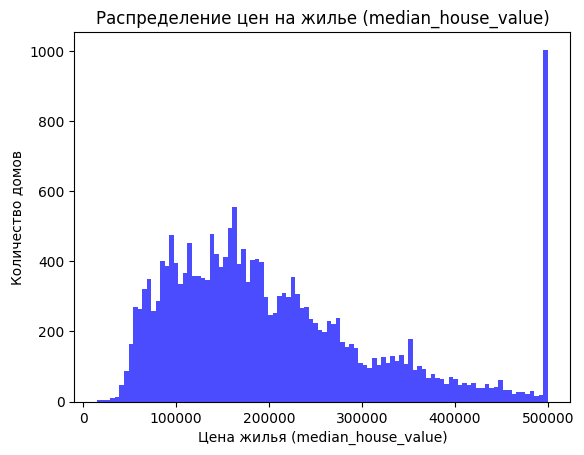

In [10]:
import matplotlib.pyplot as plt
plt.hist(df['median_house_value'], bins=100, color='blue', alpha=0.7)
plt.title('Распределение цен на жилье (median_house_value)')
plt.xlabel('Цена жилья (median_house_value)')
plt.ylabel('Количество домов')
plt.show()

Видим, что наше распределение достаточно странное, в датасете очень много тех значений которые превосходят 490000. То есть у нас есть группа очень дорогого жилья, которая будет, скорее всего, достаточно сильно портить наши предсказания, поэтому уберем их из датасета

In [11]:
df = df[df['median_house_value'] < 490000]

Посмотрим, каково распредлеление теперь

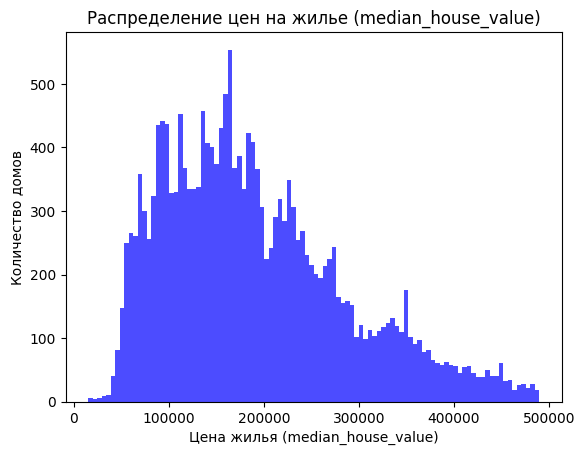

In [12]:
plt.hist(df['median_house_value'], bins=100, color='blue', alpha=0.7)
plt.title('Распределение цен на жилье (median_house_value)')
plt.xlabel('Цена жилья (median_house_value)')
plt.ylabel('Количество домов')
plt.show()

Займемся очисткой выбросов. Определять их будем достаточно базово: с помощью интерквартильного размаха, а именно

1) Найдем 1 и 3 квартили, а также интерквартильный размах

2) После этого найдем нижнюю границу - она должна быть на 1,5 интерквартильных размаха меньше, чем значение 1 квартиля. Верхняя граница же в свою очередь должна быть больше на 1,5 интерквартильных размаха, чем значение 3 квартиля

3) Дальше оставим только те строки, значение медианной цены в которых выше нижней границы и не превосходят верхнюю

In [13]:
print(f'Количество строк до удаления выбросов: {len(df)}')
Q1 = df['median_house_value'].quantile(0.25)
Q3 = df['median_house_value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['median_house_value'] >= lower_bound) & (df['median_house_value'] <= upper_bound)]
print(f'Количество строк после удаления выбросов: {len(df)}')

Количество строк до удаления выбросов: 19408
Количество строк после удаления выбросов: 19109


Было удалено порядка 300 строк, еще раз посмотрим на распределение наших данных

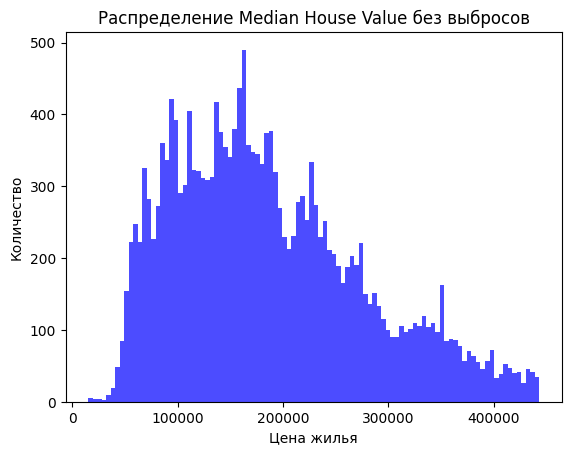

In [14]:
plt.hist(df['median_house_value'], bins=100, color='blue', alpha=0.7)
plt.title('Распределение Median House Value без выбросов')
plt.xlabel('Цена жилья')
plt.ylabel('Количество')
plt.show()

После этого посмотрим, насколько сильно зависят наши параметры, благодаря матрице корреляций, используя heatmap из seaborn

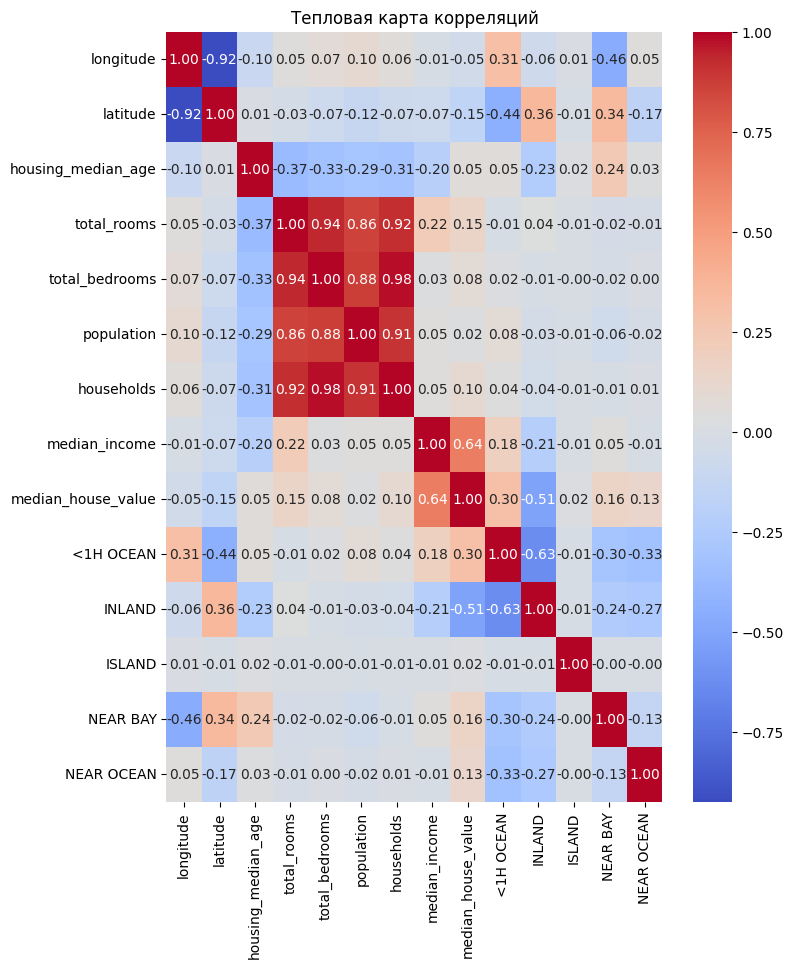

In [15]:
import seaborn as sns
corr = df.corr()
plt.figure(figsize=(8,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Тепловая карта корреляций')
plt.show()

Так как мы изучаем median_house_value, то более всего нам будет интересно посмотреть на строку с этим значением.

Очевидно, от численного значения longitude и latitude наш целевой признак почти не зависит (конечно, медианная цена зависит от конкретного местоположения, но она не зависит линейно от них в том плане, что при движении на север или в любую другу сторону непонятно, будет ли конкретно увеличиваться/уменьшаться цена).

median_income имеет умеренную положительную корреляцию с median_house_value (0.69). Это ожидаемо, так как доход домохозяйств часто влияет на стоимость жилья.

<1H OCEAN и INLAND также имеют умеренные корреляции с median_house_value (0.30 и 0.51 соответственно), что указывает на то, что близость к океану или внутренним территориям может влиять на стоимость домов.

Также количество комнат, количество людей и количество домов в локации никак не коррелируют с медианной ценной. Это логично, ведь, например, в дорогом районе может жить много людей, быть мало комнат и т.д.

Стоит отметить, что некоторые признаки сильно коррелируют между собой, что может сделать оценки регрессии неустойчивыми, было бы хорошо придумать какие-то единые значения для долготы и широты, а также отдельно значения, объединяющие total_bedrooms, total_rooms, population и house_holds, однако хотелось бы рассмотреть предсказания в условиях наличия всех этих параметров, так как есть ощущение, что, например, среднее количество людей на комнату будет важным параметром вкупе с median_income.

# 3. Построение бейзлайна и его оценивание

Как мы сказали, нашей задачей будет предсказание медианной цены на дом в данной локации в Калифорнии в зависимости от представленных параметров. Для ее решения в качестве бейзлайна было принято использовать линейную регрессию из библиотеки sklearn. Линейная регресиия - это метод машинного обучения, строящий прямую линию в случае одного признака и гиперплоскость в случае нескольких,которая наиболее лучшим образом описывает зависимость целевой переменной от признаков.


Уравнение линейной регрессии выглядит следующим образом:
$$
y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n + \varepsilon
$$

где:  
- \( $y$ \) — предсказанное значение (зависимая переменная)  
- \( $x_i$ \) — признаки (независимые переменные)  
- \( $w_i$ \) — коэффициенты (веса модели)  
- \( $w_0$\) — свободный член (intercept)  
- \( $\varepsilon\$ ) — ошибка модели  

Модель обучается путем минимизации функции потерь — **среднеквадратичной ошибки (MSE)**






In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Импортируем из библиотеки sklearn модель линейной регресии, нашу метрику MSE, а также разделение на обучающую и контрольную выборки.

Удивительно, но факт, обучающая выборка используется для обучения нашей модели и подбора тех самых коэффициентов. После этого проверяется работа модели на тестовой выборке.

In [17]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f'MSE линейной регрессии: {mse}')

MSE линейной регрессии: 3128981496.4498334


Здесь мы разделили наш датасет на два: первый (X) состоит из параметров, а второй (y) из единственного значения, а именно нашей целевой переменной median_house_value. Позже мы разделили наш датасет на обучающую и тестовую выборку, во второй будет всего 20% всех данных - это мы указали в test_size, а random_state позволяет при каждом запуске кода одинаково разделять датасет на две выборки. Позже мы предсказываем значения медианной цены в квартале и кладем их в y_pred, после чего с помощью встроенной в sklearn mse смотрим на среднее квадратичное отклонение предсказанных данных от настоящих.

Очевидно, нам нужно понять разницу между предсказанием нашей моделью и предсказания константным случаем, вдруг мы делали все просто так и лучше было бы просто выводить одно значение, а не заниматься непонятным обучением? Поэтому смотрим, например, на MSE медианного предсказания, предварительно заполнив y_pred_constant медианным значением median_house_value, используя full_like из numpy

In [18]:
import numpy as np
y_pred_constant = np.full_like(y_test, y_train.median())
mse_constant = mean_squared_error(y_test, y_pred_constant)
print(f"MSE константного предсказания: {mse_constant}")

MSE константного предсказания: 8583512435.897436


In [19]:
print((mse_constant-mse)/mse*100)

174.32288895400487


Видим, что медианное предсказание отличается на 174% по ошибке в сравнении с моделью линейной регрессией, то есть мы делали это не зря!

# 4. Построение более сложной модели

Модель линейной регрессии предполагает лишь линейную зависимость данных. В большинстве случаев это не так, поэтому попробуем улучшить наши предсказания с помощью XGBoost и гиперпараметров

**XGBoost (Extreme Gradient Boosting)** — это высокоэффективный алгоритм машинного обучения, основанный на методе градиентного бустинга, который используется для решения задач классификации и регрессии.

**Принцип работы XGBoost:**

1) Инициализация: начинается с базовой модели (например, предсказания среднего или медианы для регрессии)

2) Обучение деревьев: затем XGBoost обучает деревья решений, где каждое новое дерево направлено на минимизацию ошибки предыдущего. Ошибки вычисляются как остаточные ошибки между фактическими значениями и предсказаниями предыдущих деревьев.

3) Объединение деревьев: модели создаются по принципу "усреднения", где все обученные деревья объединяются в одну итоговую модель для получения финального предсказания.

4) Моделирование градиентов: важно то, что XGBoost использует градиенты для обновления весов моделей, что помогает минимизировать ошибку при каждом шаге.

5) Регуляризация: XGBoost использует регуляризацию для снижения сложности модели, что помогает предотвратить переобучение, улучшая способность модели обобщать на новых данных.




**Параметры XGBoost:**

n_estimators: количество деревьев в модели.

learning_rate (или eta): скорость обучения, которая контролирует, как сильно каждый шаг модели влияет на результат.

max_depth: максимальная глубина дерева, которая ограничивает количество уровней дерева, предотвращая переобучение.

subsample: доля данных, которая используется для обучения каждого дерева (от 0.5 до 1).

colsample_bytree: доля признаков, используемых для построения каждого дерева.
objective: функция потерь, которую нужно минимизировать (например, "reg:squarederror" для регрессии).

eval_metric: метрика для оценки качества модели на каждой итерации (например, "rmse" для корня из средней квадратичной ошибки).

booster: тип используемого бустинга, может быть "gbtree" (деревья решений),
"gblinear" (линейная модель) или "dart" (деревья с случайными выбросами).
Основные особенности XGBoost:

Можно избежать настраивания гиперпараметров вручную с помощью Optuna. Optuna помогает автоматически искать оптимальные гиперпараметры для модели, а также хорошо интегрируется с XGBoost.

In [20]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 13.3 MB/s eta 0:00:00


In [21]:
import optuna
import xgboost as xgb
from sklearn.datasets import fetch_california_housing

Дальше нам необходимо создать функцию, в которой опишем гиперпараметры для нашей модели, а именно:

n_estimators - число деревьев в ансамбле (от 100 до 500)

max_depth - Максимальная глубина дерева (от 3 до 10)

learning_rate - Скорость обучения (от 0.01 до 0.3) с логарифмическим распределением (то есть фокусируемся на более мелких значениях скорости)

subsample - доля выборки для обучения каждого дерева (от 0.5 до 1.0).

colsample_bytree - доля признаков, используемых для построения каждого дерева (от 0.5 до 1.0).

Также необходимо задать нашу модель XGB, которая будет использоваться для регрессии на основе градиентного бустинга с заданными выше параметрами, после чего смотрим на точность предсказания с помощью все той же метрики MSE

In [22]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

Оказалось, что для коррекnной работы нельзя иметь в названии столбцов <, поэтому столбец <1H OCEAN переименуем в LESS 1H OCEAN

In [23]:
X_train = X_train.rename(columns={'<1H OCEAN': 'LESS 1H OCEAN'})
X_test = X_test.rename(columns={'<1H OCEAN': 'LESS 1H OCEAN'})

Теперь нужно создать объект для оптимизации гиперпараметров для минимизации метрики и запустить поиск лучших гиперпараметров, которые будет использоваться в нашей модели

In [24]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-03-26 19:34:56,983] A new study created in memory with name: no-name-b9f704a8-beee-4b80-a3f3-7040ab654235
<ipython-input-22-fcaa0f5d1cb5>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-22-fcaa0f5d1cb5>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-22-fcaa0f5d1cb5>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5,

In [25]:
best_params = study.best_params
model = xgb.XGBRegressor(**best_params, random_state=42)

Видим, что наша модель готова, настало время использовать ее для предсказания!

In [26]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка (MSE): {mse}")

Среднеквадратичная ошибка (MSE): 1343979988.460487


In [27]:
print(f'MSE XGBoost в {3128981496.4498334/mse} раз меньше, чем MSE линейной регрессии')

MSE XGBoost в 2.328145897495129 раз меньше, чем MSE линейной регрессии


Получился хороший результат, ошибка уменьшилась в 2 раза!

## 5. Интерпретация полученной сложной модели

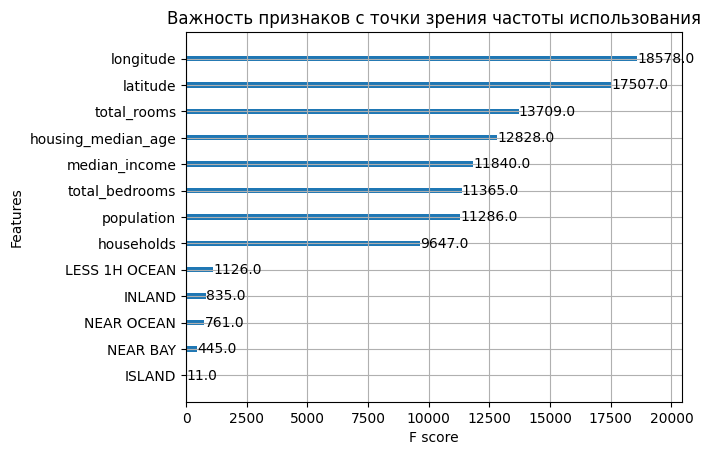

In [28]:
xgb.plot_importance(model, importance_type='weight')
plt.title('Важность признаков с точки зрения частоты использования')
plt.show()

Видим, что наиболее часто в решающих деревьях для следующих действий использовались параметры, которые указаны на графике выше. Очевидно, эти данные нельзя сопоставить с помощью в точности предсказаний для нашей модели

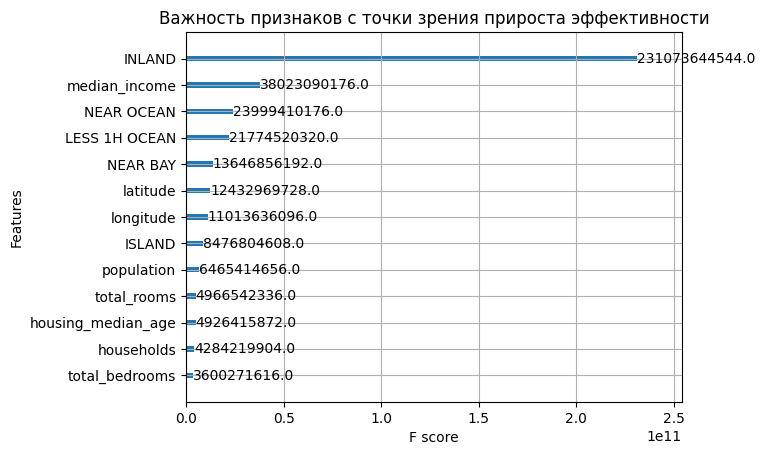

In [29]:
xgb.plot_importance(model, importance_type='gain')
plt.title('Важность признаков c точки зрения прироста эффективности')
plt.show()

Видим, что наиболее важным с точки зрения прироста эффективности оказался INLAND

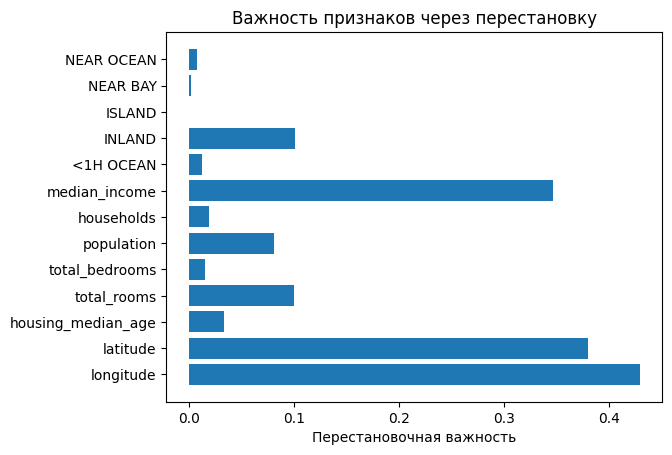

In [30]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

plt.barh(range(X_test.shape[1]), result.importances_mean)
plt.yticks(range(X_test.shape[1]), X.columns)
plt.xlabel('Перестановочная важность')
plt.title('Важность признаков через перестановку')
plt.show()

Модель в значительной степени опирается на географические координаты (широта/долгота) и доход населения при предсказании целевой переменной. Остальные признаки оказывают меньший эффект с точки зрения перестановочной важности